In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import featuretools as ft
import featuretools.variable_types as vtypes
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
os.chdir('c:\\Users\\Artem\\Desktop\\neural networks\\HTRU2')
os.getcwd()

'c:\\Users\\Artem\\Desktop\\neural networks\\HTRU2'

In [3]:
data = pd.read_csv('HTRU_2.csv', header=None)
column_names = pd.read_csv('columns_names.txt',sep=" ", header=None)
data.columns = ["MeanIP","StdIP","ExckurtIP","SkewIP","MeanDMSNR","StdDMSNR","ExckurtDMSNR","SkewDMSNR", "class"]

In [4]:
data.columns = data.columns.map(str)

In [5]:
def plot_metrics(history): #для графиков функции потерь и точности в зависимости от эпохи
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+2)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1.2])

    plt.legend()

    

In [6]:
def plot_cm(labels, predictions, p=0.5): #для confusion_matrix
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('всего 27 "пульсаров"')
  print('всего 1763 "не пульсаров"')
  print('не пульсар предсказанный как не пульсар: ', cm[0][0])
  print('не пульсар предсказанный как пульсар :', cm[0][1])
  print('пульсар предсказанный как не пульсар :', cm[1][0])
  print('пульсар предсказанный как пульсар : ', cm[1][1])
  print('количество правильных ответов', np.sum([cm[0][0],cm[1][1]]), 'из 1790')

In [7]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

In [8]:

plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
del data['class'] #удаляется последняя колонка с ответами для feature engeneering

In [10]:
ft.list_primitives()

,name,type,description
0,time_since_first,aggregation,Calculates the time elapsed since the first da...
1,num_unique,aggregation,"Determines the number of distinct values, igno..."
2,median,aggregation,Determines the middlemost number in a list of ...
3,any,aggregation,Determines if any value is 'True' in a list.
4,percent_true,aggregation,Determines the percent of `True` values.
5,mode,aggregation,Determines the most commonly repeated value.
6,entropy,aggregation,Calculates the entropy for a categorical variable
7,max,aggregation,"Calculates the highest value, ignoring `NaN` v..."
8,std,aggregation,Computes the dispersion relative to the mean v...
9,sum,aggregation,"Calculates the total addition, ignoring `NaN`."


In [11]:
# creating and entity set 'es' #начинается работа над генерацией признаков с помощью feature engineering.
es = ft.EntitySet(id = 'pulsars')
# adding a dataframe 
es.entity_from_dataframe(entity_id = 'signals', dataframe = data, index='number')

2020-05-22 23:08:23,224 featuretools.entityset - WARNING    index number not found in dataframe, creating new integer column


Entityset: pulsars
  Entities:
    signals [Rows: 17898, Columns: 9]
  Relationships:
    No relationships

In [12]:
es["signals"].variables 

[<Variable: number (dtype = index)>,
 <Variable: MeanIP (dtype = numeric)>,
 <Variable: StdIP (dtype = numeric)>,
 <Variable: ExckurtIP (dtype = numeric)>,
 <Variable: SkewIP (dtype = numeric)>,
 <Variable: MeanDMSNR (dtype = numeric)>,
 <Variable: StdDMSNR (dtype = numeric)>,
 <Variable: ExckurtDMSNR (dtype = numeric)>,
 <Variable: SkewDMSNR (dtype = numeric)>]

In [13]:
feature_matrix, feature_names=ft.dfs(entityset=es, target_entity = 'signals',max_depth = 3, verbose = 3, n_jobs = 1)
feature_matrix.head() #при первой попытке генрации признаков(при "no relationships" ничего не сгенерировалось)

Built 8 features
Elapsed: 00:00 | Progress: 100%|██████████


,MeanIP,StdIP,ExckurtIP,SkewIP,MeanDMSNR,StdDMSNR,ExckurtDMSNR,SkewDMSNR
number,,,,,,,,
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306


In [15]:
es = es.normalize_entity(base_entity_id='signals', new_entity_id='new_signals', index='MeanIP') #создаём relationship: выделяем столбец, на основе которого будут строиться общие признаки

In [16]:
print(es)

Entityset: pulsars
  Entities:
    signals [Rows: 17898, Columns: 9]
    new_signals [Rows: 8626, Columns: 1]
  Relationships:
    signals.MeanIP -> new_signals.MeanIP


In [17]:
feature_matrix, feature_names=ft.dfs(entityset=es, target_entity = 'signals',agg_primitives=["mean", "max","min", "sum", "median"], max_depth=5)
feature_matrix.head(15)

,MeanIP,StdIP,ExckurtIP,SkewIP,MeanDMSNR,StdDMSNR,ExckurtDMSNR,SkewDMSNR,new_signals.MEAN(signals.MeanDMSNR),new_signals.MEAN(signals.SkewDMSNR),...,new_signals.SUM(signals.StdIP),new_signals.SUM(signals.SkewIP),new_signals.SUM(signals.StdDMSNR),new_signals.MEDIAN(signals.MeanDMSNR),new_signals.MEDIAN(signals.SkewDMSNR),new_signals.MEDIAN(signals.ExckurtDMSNR),new_signals.MEDIAN(signals.ExckurtIP),new_signals.MEDIAN(signals.StdIP),new_signals.MEDIAN(signals.SkewIP),new_signals.MEDIAN(signals.StdDMSNR)
number,,,,,,,,,,,,,,,,,,,,,
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,3.199833,74.242225,...,55.683782,-0.699648,19.110426,3.199833,74.242225,7.975532,-0.234571,55.683782,-0.699648,19.110426
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,2.066332,110.547849,...,160.533606,-0.404816,45.756319,1.836957,127.393580,10.360940,0.452962,52.275860,-0.246135,14.860146
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,2.757107,85.309060,...,88.082191,1.273260,36.393436,2.757107,85.309060,8.400171,0.466137,44.041095,0.636630,18.196718
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,3.258361,71.589360,...,157.041468,-1.103265,58.706194,3.326923,67.242135,7.752153,-0.068415,49.955605,-0.375633,20.725051
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,1.178930,252.567306,...,40.672225,1.123492,11.468720,1.178930,252.567306,14.269573,0.600866,40.672225,1.123492,11.468720
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,7.000000,72.641038,...,90.217808,2.066170,66.592926,7.000000,72.641038,7.301360,0.619374,45.108904,1.033085,33.296463
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,38.548495,165.400459,...,189.047439,0.170001,129.733021,2.663462,91.395097,8.464385,0.054479,47.513018,0.066080,16.192914
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,2.247492,125.717906,...,141.668487,-0.452515,51.905838,2.678094,106.652628,9.391858,-0.158323,50.379206,-0.117718,16.535941
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,2.886407,128.005504,...,348.057879,0.240581,124.083662,2.331940,107.972506,9.001004,0.329787,48.306153,0.123002,14.486853


In [17]:
feature_matrix=feature_matrix.to_numpy() # начинается подготовка данных для сети

In [18]:
xf_train, xf_valid, xf_test=np.split(feature_matrix, [14318,16108]) # подборка данных с feature engeneering

In [19]:
weight_for_0 = (1 / 16259)*(17898)/2.0 #замена значений весов
weight_for_1 = (1 / 1639)*(17898)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [20]:
#Ещё раз приходится считывать массив исходных данных data, поскольку до этого нужно было удалить столбец

data = pd.read_csv('HTRU_2.csv', header=None) 
column_names = pd.read_csv('columns_names.txt',sep=" ", header=None)
data.columns = ["MeanIP","StdIP","ExckurtIP","SkewIP","MeanDMSNR","StdDMSNR","ExckurtDMSNR","SkewDMSNR", "class"]

In [21]:
data=data.to_numpy()

In [22]:
x, y, z=np.split(data, [14318,16108])

In [23]:
x_train, y_train=np.hsplit(x, [8]) #нарезаем на тренировку
x_valid, y_valid=np.hsplit(y, [8]) #нарезаем на валидацию
x_test, y_test=np.hsplit(z,[8]) #нарезаем на тест

In [24]:
#Для данных без feature engeneering и без пересчёта веса класса.

model = tf.keras.models.Sequential([
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history=model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), shuffle=True)
model.evaluate(x_test, y_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 5:12 - loss: 38.5240 - accuracy: 0.375 - ETA: 7s - loss: 9.7142 - accuracy: 0.6599  - ETA: 3s - loss: 7.3697 - accuracy: 0.72 - ETA: 1s - loss: 5.9057 - accuracy: 0.75 - ETA: 1s - loss: 4.9900 - accuracy: 0.77 - ETA: 0s - loss: 4.3967 - accuracy: 0.78 - ETA: 0s - loss: 3.9045 - accuracy: 0.80 - ETA: 0s - loss: 3.5206 - accuracy: 0.81 - ETA: 0s - loss: 3.2173 - accuracy: 0.82 - ETA: 0s - loss: 2.9995 - accuracy: 0.82 - 1s 89us/sample - loss: 2.9886 - accuracy: 0.8262 - val_loss: 0.0729 - val_accuracy: 0.9911
Epoch 2/100
14318/14318 [==============================] - ETA: 0s - loss: 2.1490 - accuracy: 0.90 - ETA: 0s - loss: 0.9256 - accuracy: 0.88 - ETA: 0s - loss: 0.8445 - accuracy: 0.88 - ETA: 0s - loss: 0.8108 - accuracy: 0.87 - ETA: 0s - loss: 0.7398 - accuracy: 0.87 - ETA: 0s - loss: 0.7073 - accuracy: 0.88 - ETA: 0s - loss: 0.6701 - accuracy: 0.88 - ETA: 0s - loss: 0.641

[0.05196929413346605, 0.98826814]

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  144       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  33        
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None


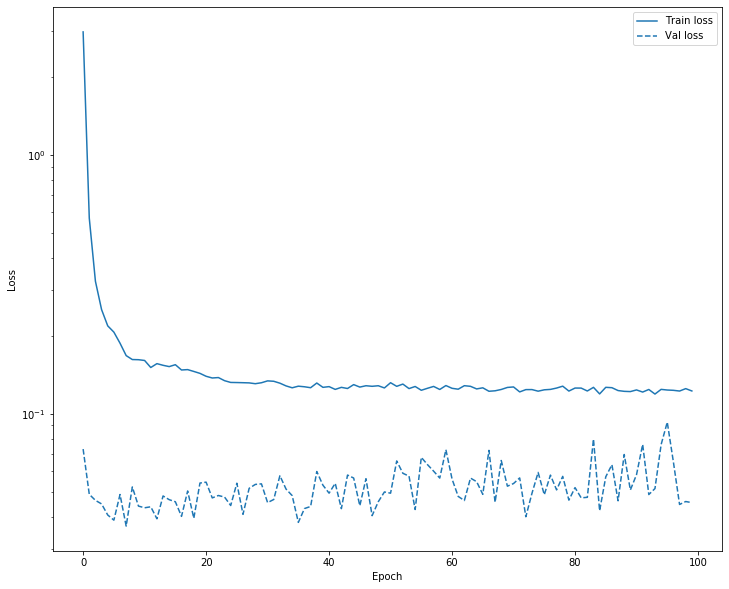

In [26]:
plot_loss(baseline_history, 'loss', 0)

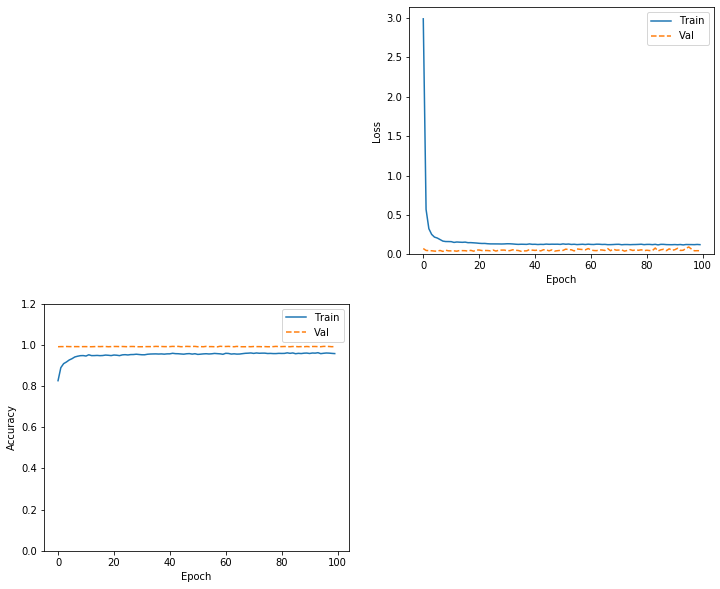

In [27]:
plot_metrics(baseline_history)

loss :  0.05196929413346605
accuracy :  0.98826814

всего 27 "пульсаров"
всего 1763 "не пульсаров"
не пульсар предсказанный как не пульсар:  1755
не пульсар предсказанный как пульсар : 8
пульсар предсказанный как не пульсар : 13
пульсар предсказанный как пульсар :  14
количество правильных ответов 1769 из 1790


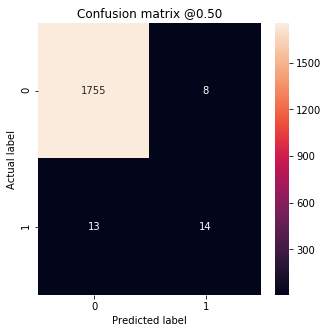

In [28]:
#для данных с feature engeneering

test_predictions_baseline = model.predict(x_test)

baseline_results = model.evaluate(x_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [29]:
# далее всё тоже самое, только с данными без feature engeneering, но с пересчётом веса класса

In [30]:
#Для данных без feature engeneering, но с пересчётом веса класса

model = tf.keras.models.Sequential([
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history1=model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), shuffle=True, class_weight=class_weight)
model.evaluate(x_test, y_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 4:38 - loss: 16.4579 - accuracy: 0.406 - ETA: 5s - loss: 13.3686 - accuracy: 0.5006  - ETA: 2s - loss: 11.3777 - accuracy: 0.535 - ETA: 1s - loss: 10.3007 - accuracy: 0.567 - ETA: 1s - loss: 9.3039 - accuracy: 0.580 - ETA: 0s - loss: 8.2828 - accuracy: 0.59 - ETA: 0s - loss: 7.6772 - accuracy: 0.61 - ETA: 0s - loss: 7.1004 - accuracy: 0.61 - ETA: 0s - loss: 6.5474 - accuracy: 0.62 - ETA: 0s - loss: 6.1171 - accuracy: 0.62 - 1s 91us/sample - loss: 5.7946 - accuracy: 0.6338 - val_loss: 0.2369 - val_accuracy: 0.9425
Epoch 2/100
14318/14318 [==============================] - ETA: 0s - loss: 2.7238 - accuracy: 0.68 - ETA: 0s - loss: 1.7358 - accuracy: 0.67 - ETA: 0s - loss: 1.9813 - accuracy: 0.69 - ETA: 0s - loss: 1.7968 - accuracy: 0.69 - ETA: 0s - loss: 1.7986 - accuracy: 0.69 - ETA: 0s - loss: 1.6762 - accuracy: 0.69 - ETA: 0s - loss: 1.5773 - accuracy: 0.69 - ETA: 0s - loss:

[0.20917624711324384, 0.975419]

In [31]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  144       
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  544       
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  33        
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None


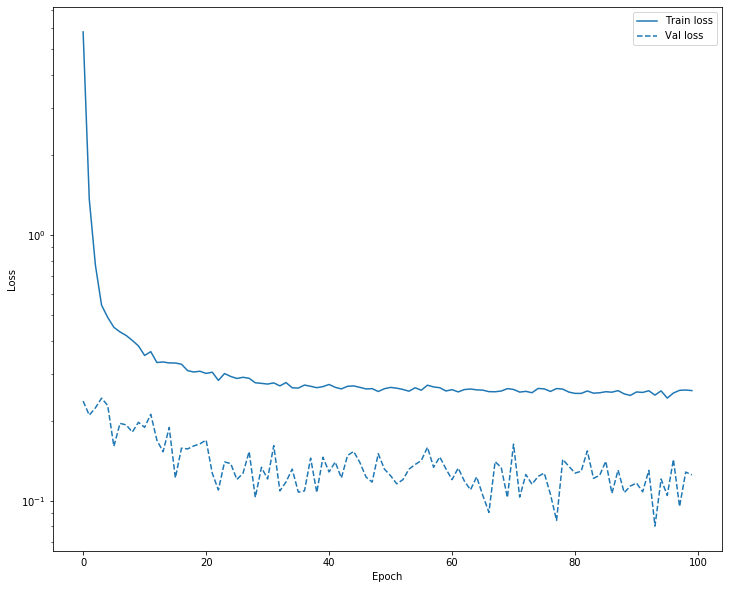

In [32]:
plot_loss(baseline_history1, 'loss', 0)

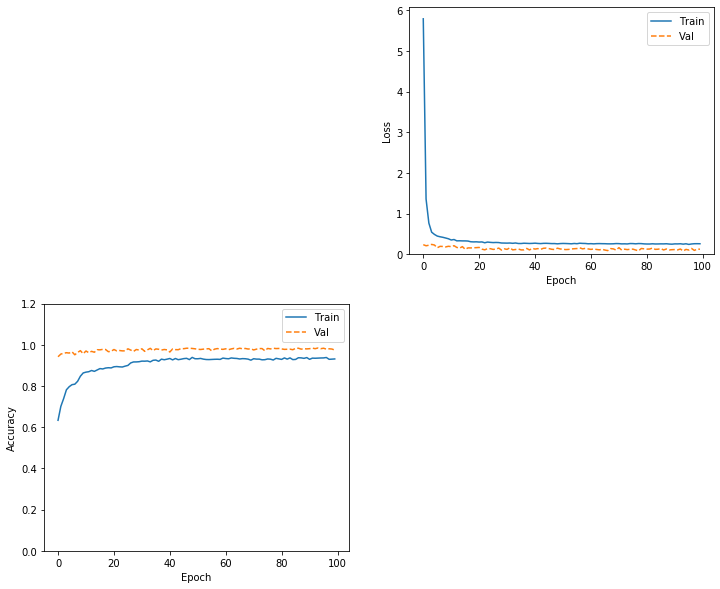

In [33]:
plot_metrics(baseline_history1)

loss :  0.20917624711324384
accuracy :  0.975419

всего 27 "пульсаров"
всего 1763 "не пульсаров"
не пульсар предсказанный как не пульсар:  1722
не пульсар предсказанный как пульсар : 41
пульсар предсказанный как не пульсар : 3
пульсар предсказанный как пульсар :  24
количество правильных ответов 1746 из 1790


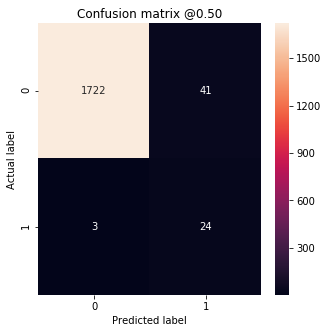

In [34]:
#для данных без feature engeneering


test_predictions_baseline = model.predict(x_test)

baseline_results = model.evaluate(x_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [35]:
# далее всё тоже самое, только с центрированными данными

In [36]:
datanorm = pd.read_csv('пульсары центрированные данные.csv', header=None)
#path = 'пульсары нормализованные.csv'
#myfile = open(path, mode = 'a')

In [37]:
datanorm.shape

(17898, 9)

In [38]:
datanorm=datanorm.to_numpy()

In [39]:
a, b, c=np.split(datanorm, [14318,16108])

In [40]:
a_train, b_train=np.hsplit(a, [8]) #нарезаем на тренировку
a_valid, b_valid=np.hsplit(b, [8]) #нарезаем на валидацию
a_test, b_test=np.hsplit(c,[8]) #нарезаем на тест

In [41]:
#модель с центрированными данными
model = tf.keras.models.Sequential([

tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history2=model.fit(a_train, b_train, epochs=100, validation_data=(a_valid, b_valid), shuffle=True, class_weight=class_weight)
model.evaluate(a_test, b_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 4:28 - loss: 3.8886 - accuracy: 0.56 - ETA: 5s - loss: 11.4964 - accuracy: 0.5449 - ETA: 2s - loss: 9.5684 - accuracy: 0.570 - ETA: 1s - loss: 8.1080 - accuracy: 0.59 - ETA: 1s - loss: 7.2809 - accuracy: 0.59 - ETA: 0s - loss: 6.5388 - accuracy: 0.60 - ETA: 0s - loss: 5.9847 - accuracy: 0.60 - ETA: 0s - loss: 5.4862 - accuracy: 0.61 - ETA: 0s - loss: 5.0134 - accuracy: 0.61 - ETA: 0s - loss: 4.6138 - accuracy: 0.62 - 1s 88us/sample - loss: 4.4600 - accuracy: 0.6266 - val_loss: 0.1424 - val_accuracy: 0.9743
Epoch 2/100
14318/14318 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.78 - ETA: 0s - loss: 1.0486 - accuracy: 0.70 - ETA: 0s - loss: 0.9988 - accuracy: 0.69 - ETA: 0s - loss: 0.9731 - accuracy: 0.69 - ETA: 0s - loss: 0.9182 - accuracy: 0.70 - ETA: 0s - loss: 0.8881 - accuracy: 0.70 - ETA: 0s - loss: 0.8614 - accuracy: 0.70 - ETA: 0s - loss: 0.8299

[0.2177614570329975, 0.9743017]

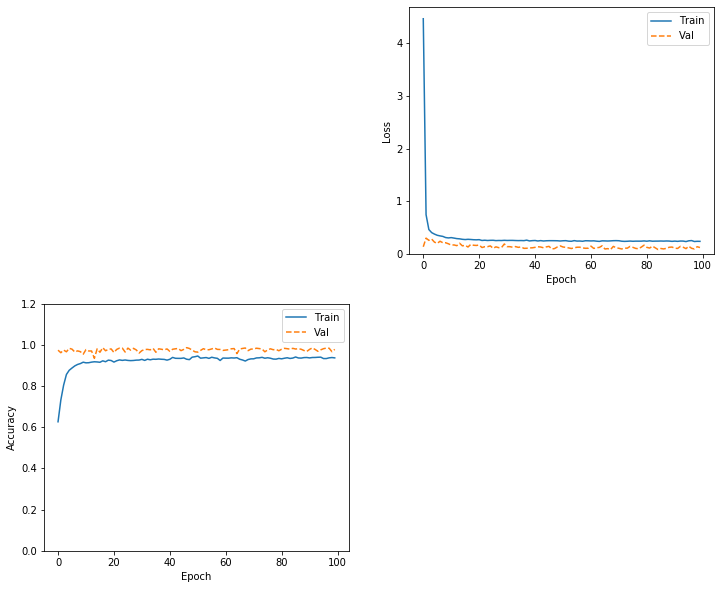

In [42]:
plot_metrics(baseline_history2)

loss :  0.2177614570329975
accuracy :  0.9743017

всего 27 "пульсаров"
всего 1763 "не пульсаров"
не пульсар предсказанный как не пульсар:  1720
не пульсар предсказанный как пульсар : 43
пульсар предсказанный как не пульсар : 3
пульсар предсказанный как пульсар :  24
количество правильных ответов 1744 из 1790


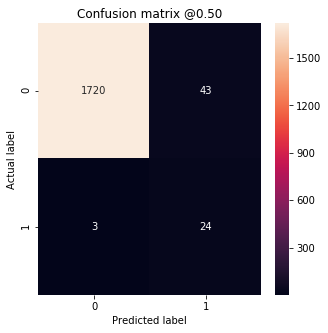

In [43]:
test_predictions_baseline = model.predict(a_test)
baseline_results = model.evaluate(a_test, b_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(b_test, test_predictions_baseline)

In [44]:
#Для данных с feature engeneering

model = tf.keras.models.Sequential([

tf.keras.layers.Dense(100, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(200, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history3=model.fit(xf_train, y_train, epochs=100, validation_data=(xf_valid, y_valid), shuffle=True, class_weight = class_weight)
model.evaluate(xf_test, y_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 4:39 - loss: 60.8960 - accuracy: 0.437 - ETA: 8s - loss: 13.7579 - accuracy: 0.7783  - ETA: 4s - loss: 9.1839 - accuracy: 0.827 - ETA: 2s - loss: 8.4659 - accuracy: 0.80 - ETA: 1s - loss: 8.1503 - accuracy: 0.79 - ETA: 1s - loss: 7.4424 - accuracy: 0.80 - ETA: 1s - loss: 7.0805 - accuracy: 0.79 - ETA: 0s - loss: 6.4310 - accuracy: 0.80 - ETA: 0s - loss: 5.9524 - accuracy: 0.79 - ETA: 0s - loss: 5.5688 - accuracy: 0.80 - ETA: 0s - loss: 5.1883 - accuracy: 0.80 - ETA: 0s - loss: 4.8843 - accuracy: 0.80 - ETA: 0s - loss: 4.5923 - accuracy: 0.80 - 1s 101us/sample - loss: 4.4949 - accuracy: 0.8079 - val_loss: 0.1774 - val_accuracy: 0.9458
Epoch 2/100
14318/14318 [==============================] - ETA: 1s - loss: 0.5952 - accuracy: 0.87 - ETA: 0s - loss: 1.8749 - accuracy: 0.86 - ETA: 0s - loss: 1.8315 - accuracy: 0.82 - ETA: 0s - loss: 1.6225 - accuracy: 0.82 - ETA: 0s - loss: 1.

[0.14739838046068585, 0.98324025]

In [45]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              multiple                  4400      
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  20200     
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  201       
Total params: 24,801
Trainable params: 24,801
Non-trainable params: 0
_________________________________________________________________
None


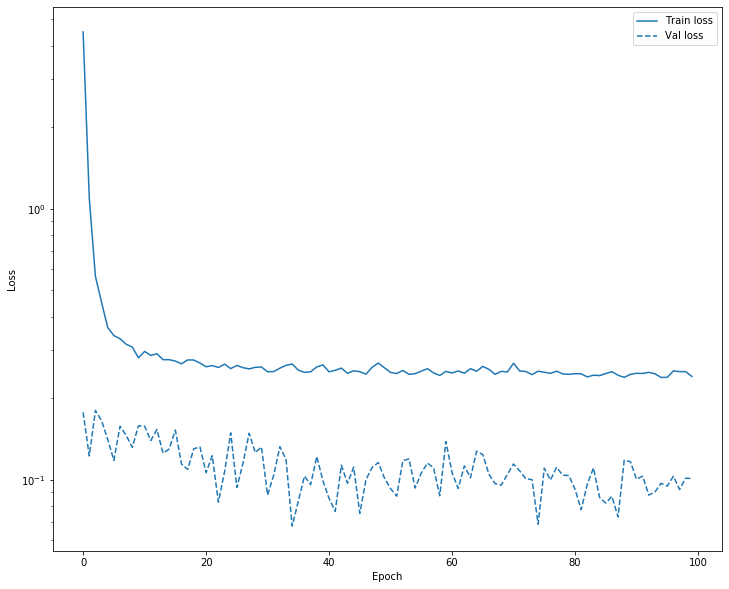

In [46]:
plot_loss(baseline_history3, 'loss', 0)

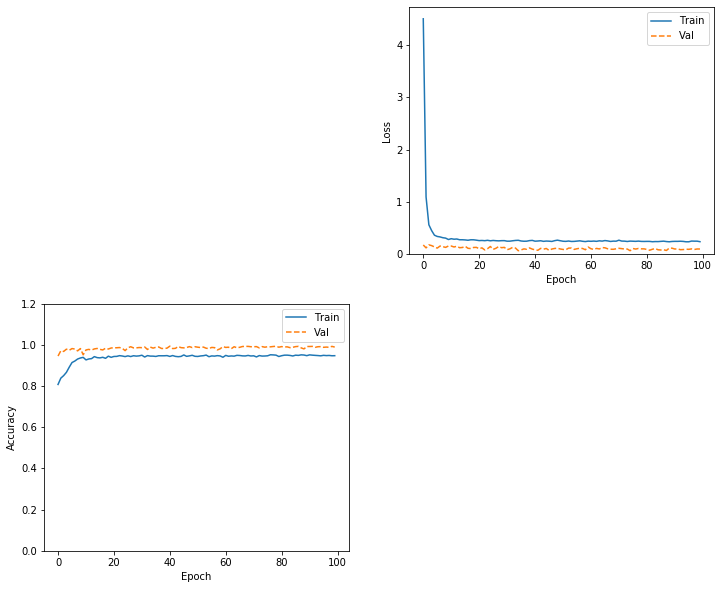

In [47]:
plot_metrics(baseline_history3)

loss :  0.14739838046068585
accuracy :  0.98324025

всего 27 "пульсаров"
всего 1763 "не пульсаров"
не пульсар предсказанный как не пульсар:  1743
не пульсар предсказанный как пульсар : 20
пульсар предсказанный как не пульсар : 10
пульсар предсказанный как пульсар :  17
количество правильных ответов 1760 из 1790


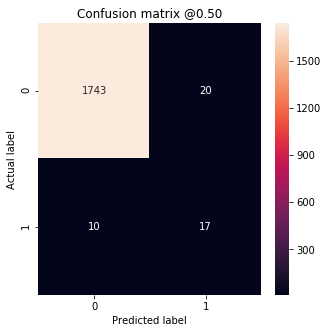

In [48]:
#для данных с feature engeneering

test_predictions_baseline = model.predict(xf_test)

baseline_results = model.evaluate(xf_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

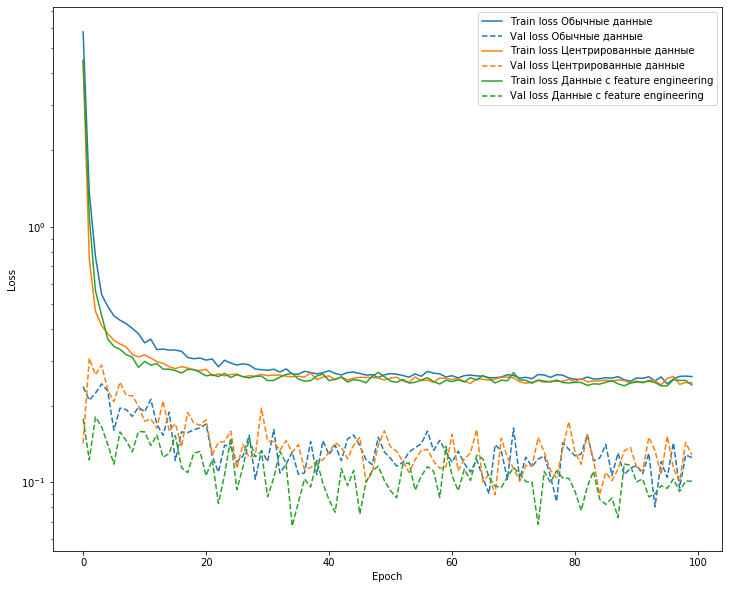

In [49]:
plot_loss(baseline_history1, 'loss Обычные данные', 0)
plot_loss(baseline_history2, 'loss Центрированные данные', 1)
plot_loss(baseline_history3, 'loss Данные с feature engineering', 2)

#график для обучения со всеми типами данных